In [ ]:
# Execute this first 
#
#  * trigger notebook styling
#  * check if notebook had been modified since its distribution
# 
# Note: executing any cells before this modifies the notebook.
# 
%run src/init_notebooks.py
hide_toggle()
check_notebook()

# REMD simulations in GROMACS

    authors  : Artem Zhmurov and Mark Abraham.    
    goal     : learn step-by-step how to perform temperature REMD on a small peptide in explicit solvent 
    time     : 90 minutes
    software : GROMACS 2021, python modules: numpy, matplotlib, re, nglviewer, md_traj, panda 
    optional software for local installation: visualization software[VMD](https://www.ks.uiuc.edu/Research/vmd), Xmgrace plotting tool, MPI version of GROMACS
    version  : release


## Overview

This tutorial comes in two parts. In the first, the theory behind replica exchange simulations will be briefly described. Then, we will look at how to perform temperature REMD on a small peptide in explicit solvent.

![Random landscape figure from the internet](figures/01-homepage-rotating-image.jpg).

## Theory of replica exchange simulations

Many molecular simulation scenarios require ergodic sampling of energy landscapes that feature many minima. Often the barriers between minima can be difficult to cross at ambient temperatures over accessible simulation time scales. This means that results are often confounded by the choice of initial conditions, because the simulation never leaves that space.

Replica exchange simulations seek to enhance the sampling in such scenarios by running numerous independent replicas in slightly different ensembles, and periodically exchanging the coordinates of replicas between the ensembles. Typically, the set of replicas is constructed so that one extreme of the set of replicas is the ensemble from which sampling is wanted, and the other extreme is one where barriers can be crossed more easily. So, if

* the attempts to exchange replicas between ensemble produce valid ensembles,
* the probability of exchange attempts succeeding is high enough, and
* the resulting flow of replicas over the ensembles produces good mixing,

then the resulting sampling will be statistically correct and closer to the ergodic ideal.

How can this work? It relies on doing Monte Carlo moves of replicas between ensembles. The probability of observing a replica in a particular state depends on the potential energy and the temperature, i.e.

$$P(x) \propto \exp^{-\frac{U(x)}{k_B T}}$$

The range of potential energies that is observed follows a normal distribution (because of the Central Limit Theorem). If two ensembles are chosen so that the set of states have significant overlap in the resulting potential energy distributions, then when we observe a state in one ensemble there is appreciable chance that it could have been observed in the other.

![Potential energy distributions of alanine dipeptide replicas.](figures/combined-pot.jpg)

This allows us to construct a Metropolis-style Monte Carlo move that proposes that we exchange the coordinates found in two replicas based upon the probabilities that they would have been observed in the two ensembles. The exchange probability between states `S1` and `S2` is computed as:

$$P(S1\leftrightarrow S2)=\min(1,e^{-\Delta})$$

where

$$\Delta=(\beta_{S2}-\beta_{S1})(U_{S1}-U_{S2})$$


The exchange is accepted only if a random number has a suitable value. When done correctly, detailed balance is achieved, and the sampling in both ensembles is correct whether or not an exchange took place.

What range of ensembles should be chosen? The method of REMD (also known as parallel tempering) conducts the same simulation over a range of temperatures. We don't have to choose temperatures, but it's convenient and easy to understand. The highest temperature is chosen so that the barriers will be crossed. Replicas wander up and down through temperature space as exchanges are accepted. Barriers are crossed probabilistically at all of the temperatures, but at a higher rate at the higher temperatures. Those states filter down to the lower temperatures if they "belong" to the corresponding ensembles. In this way, the ergodicity of the sampling is enhanced.


On REMD for peptide folding see [Reproducible Polypeptide Folding and Structure Prediction using Molecular Dynamics Simulations](https://doi.org/10.1016/j.jmb.2005.09.030) by Seibert, Patriksson, Hess and van der Spoel.

On REMD for amyloid peptide aggregation see [Replica exchange molecular dynamics simulations of amyloid peptide aggregation](https://doi.org/10.1063/1.1809588) by Cecchini, Rao, Seeber, and Caflisch .


Other examples

Drug reporpusing: [https://www.nature.com/articles/s41598-020-61132-w](https://www.nature.com/articles/s41598-020-61132-w). Also see the papers by Sugita Okamoto and Ulrich Hansmann.

## System preparation

First change to the data folder.

In [1]:
%cd data
#Note that executing this command twice will result in an error you can ignore

/home/villa/git/tutorials/tutorials-in-progress/replica-exchange-molecular-dynamics/data




### Files, supplied with this tutorial

All the files, needed to run this tutorial are located in ``input`` folder. There are not so many: initial coordinates and a couple of .mdp files. The ``equil.mdp`` and ``sim.mdp`` are going to be used for production runs. These have ``XXXXXX`` instead of temperature values, which will be replaced with corresponding value for each of the replicas later on.

We start with the basic PDB file, containing coordinates for alanine tripeptide:

In [ ]:
!ls input

We start to visualize the PDB file, containing coordinates for alanine tripeptide:

In [ ]:
import nglview as ng
view = ng.show_structure_file("input/alanine_tripeptide.pdb")
view
# click and drag to rotate, zoom with your mouseweel \n",
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview"

In [ ]:
#!vmd input/alanine_tripeptide.pdb

As usual, the system has to be solvated, energy minimized and equilibrated. We will create a separate folder, called ``prep`` for that. We will use CHARMM force-field with TIP3P water model. The ``mdp`` files for energy minimization (``min.mdp``) and initial equilibration (``nvt.mdp``) can be found in ``input`` folder. For the purpose of this tutorial and given the system size, this should be sufficient to prepare the system. There is nothing different about this stage in REMD simulations, so you should use your normal routines when preparing the system. All the preparatory steps for our small system are collected in the cell below.

Note that running the cell below will clear the contents of the prep folder if you happen to have one. It should not take more than a couple of minutes, depending on your hardware. There is also a reference data, that comes with this tutorial, so you can skip the cell below, uncoment and run the cell after it. To uncomment, remove the comment character (#).

In [ ]:
%%bash
rm -rf prep
mkdir prep
cd prep
gmx pdb2gmx -f ../input/alanine_tripeptide.pdb -o alanine.gro -water tip3p -ff "charmm27"
gmx editconf -f alanine.gro -o alanine.gro -c -box 3 3 3
gmx solvate -cp alanine.gro -cs spc216.gro -o alanine.gro -p topol.top
gmx grompp -f ../input/min.mdp -c alanine.gro -p topol.top -o em.tpr
gmx mdrun -v -deffnm em
gmx grompp -f ../input/nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr 
gmx mdrun -v -deffnm nvt
cd ..

In [ ]:
#!rm -rf prep 
#!cp -r reference/prep .

Now we look at the files in prep folder

In [ ]:
!ls prep

It is always a good idea to inspect your system visually:

In [ ]:
import nglview as ng
view = ng.show_structure_file("prep/nvt.gro")
view

In [ ]:
#!vmd prep/nvt.gro

Now we are good to go with two stages of REMD simulations.

## Stage 1

### Planning an REMD simulation

There are a number of inter-connected issues to consider in designing an REMD simulation:

* What range of temperatures do I want to span?
* How many replicas will I use?
* What exchange probability should I seek?
* How much compute resource can I use?
* How will I generate my starting coordinates for each replica?

In this tutorial, these decisions are made arbitrarily, but for real studies you will want to consult the literature for guidance here. Suggested reading includes papers by David Kofke, Ulrich Hansmann, and Mark Abraham.

Temperatures should often be distributed across the replicas in a geometric progression, i.e. with the same ratio used to scale each temperature from the one below it. If the energy landscapes are sufficiently similar across the temperature space, then this will keep the overlap of the potential energy distributions constant. In turn, this will keep the probability of accepting exchanges constant. Beware, though - in real simulations you will find bottle-necks in temperature space that restrict replica flow. You should be prepared to revise your temperature scheme after some testing.

As you can read in the above literature, an exchange acceptance probability around 0.2 is generally a good idea. Often you will have to experiment with the number of replicas you need to use to span the desired temperature range to achieve about that exchange probability. If you are simulating in the NPT ensemble, you might try this [REMD temperature generator](https://github.com/dspoel/remd-temperature-generator) to help out ([http://dx.doi.org/10.1039/b716554d](http://dx.doi.org/10.1039/b716554d)).

Here, we will use only four replicas, so that the tutorial can run reasonably. Beware that you might want many hundreds of replicas to span a decent temperature range if you were looking at something like a large protein! The temperatures we will use are 300, 310, 320, and 330K.

### Question
Imagine, you have a protein that can undergo a conformational change between states S1 and S2. It was observed experimentaly, that state S1 is more probable at T < 310K and state S2 dominates at T > 310K. What set of temperatures would be preferable for REMD simulations that aim to sample the transition between S1 and S2?
1. One that have more replicas at T < 310K
2. One that have more replicas at T > 310K
3. You need more replicas around 310K
4. The transition temperature is irrelevant

### Preparing REMD equilibrations in GROMACS

Normally, `gmx mdrun` runs a single simulation. For temperature REMD we need to run a number of simulations that can communicate. This is done via the `mdrun -multidir` mechanism, which runs `N` simulations within the same program. This requires an MPI-enabled version of GROMACS (usually installed as `gmx_mpi mdrun` or `mdrun_mpi`), and `N` input `.tpr` files, each running at a different temperature. Naturally, we will have to equilibrate those to their target temperature before starting replica exchange, and that is most convenient to do with `gmx_mpi mdrun -multidir`, but this stage can also be done by cycling through the directories and running a non-MPI version of GROMACS. However, you will need MPI-enabled version for production run at Stage 2.

We need to create directories `equil0`, `equil1`, ... `equil3` inside the `stage1` directory. Each of those should contains the configuration files needed to equilibrate a simulation at the right temperature. Note that we are clearing the stage1 directory and making everything from scratch. We than copy the ``equil.mdp`` configuration file into each of the folder and replace ``XXXXXX`` with target temperature for each of the replicas. This can be conviniently done using standard linux ``sed`` utility.

In [ ]:
%%bash
rm -rf stage1
mkdir stage1
cd stage1
for i in {0..3}
do
    (mkdir equil$i; cp ../input/equil.mdp equil$i)
done

sed -i 's/XXXXXX/300/g' equil0/equil.mdp
sed -i 's/XXXXXX/310/g' equil1/equil.mdp
sed -i 's/XXXXXX/320/g' equil2/equil.mdp
sed -i 's/XXXXXX/330/g' equil3/equil.mdp

cd ..

Let us have a look at the stage1 folder: 

In [ ]:
!ls -F stage1

Let us have a look at the configuration files we will be using for equilibration:

In [ ]:
!cat stage1/equil0/equil.mdp

The files in four folders are almost identical: the only difference is the reference temperature. It is always a good idea to check the reference temperatures for the thermostats in each of the files. You can do that with a shell command like this:

In [ ]:
!grep ref_t stage1/equil*/equil.mdp

Now we want to run grompp in each directory to build the independent `.tpr` files we need. To do the first one we might chain together some bash commands so that we use `cd` to change directories and then call `gmx grompp` like

In [ ]:
!(cd stage1/equil0; gmx grompp -f equil -c ../../prep/nvt.gro -p ../../prep/topol.top)

That gets tedious when you have a lot of directories! Since we're humans, we learn to use tools to do boring things for us. The [bash](http://en.wikipedia.org/wiki/Bash_(Unix_shell)) shell lets you write a nice loop to do that operation. Here's how that looks:

In [ ]:
!(for directory in stage1/equil[0123] ; do (cd $directory; gmx grompp -f equil -c ../../prep/nvt.gro -p ../../prep/topol.top); done)

This says to loop over `equil0` ... `equil3` directories, and for each of those, change into the directory and run `gmx grompp`. This can be a tremendous time saver. Now if you do

In [ ]:
!ls stage1/equil*

you will see that there is a `topol.tpr` file in each directory. That's what we need to run `mdrun` for the equilibration, so now we're ready to roll! The following cell will run the simulation for you. This should take a couple of minutes or so, depending on your hardware. Here for practical reason we run with a non-MPI version. Note  you can run with MPI version of GROMACS if you have an MPI version installed, or you can copy the reference data if you wish so (see below).

In [ ]:
!(for directory in stage1/equil[0123] ; do (cd $directory; gmx mdrun); done)

In alternative, if you have installed a MPI version of GROMACS, uncomment by removing the character (#) and run the cell below:

In [ ]:
#!mpirun -np 4 gmx_mpi mdrun -multidir stage1/equil[0123]

To copy reference data, uncomment and run:

In [ ]:
#!(rm -rf stage1; cp -r reference/stage1 .)

Use `ls` again, and you will see that each of those directories now has a `md.log` and `ener.edr` file corresponding to the run you just did.

In [ ]:
!ls stage1/equil*

### Checking if the temperature selection was appropriate

For the purpose of the tutorial, the `.mdp` file you just used only runs a few steps. You may want to extend the equilibration run, even for a small system like ours. However, even with this short run we can do our first checks on whether our temperature selection was appropriate.

First thing to check in your output data is whether the energy distributions for different runs overlap. To do that, we extract the potential energy from GROMACS .edr file, so it can be plotted. To do that we use an interactive `gmx energy` command, which indicate that we need to extract the potential energy. This command will produce ener.xvg in each of the stage1/equil[0123] folders. 

In [ ]:
!(for directory in stage1/equil[0123] ; do (cd $directory; gmx energy -f ener.edr -o potential.xvg -xvg none <<< $'Potential\n\n'); done)

As example we plot the potential energy for equil0 (T=300K) and equil1 (T=320)

(<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>)

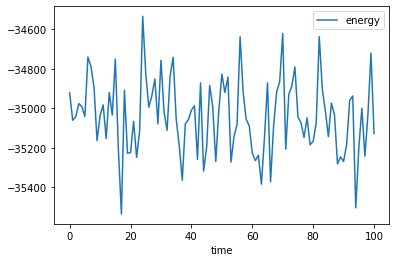

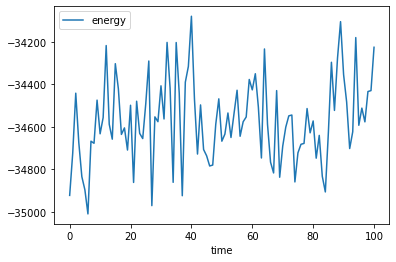

In [104]:
import pandas as pd
df=pd.read_csv('stage1/equil0/potential.xvg', sep='\\s+', header=None, names=['time','energy'])
df1=pd.read_csv('stage1/equil1/potential.xvg', sep='\\s+', header=None, names=['time','energy'])
df.plot('time'), df1.plot('time')

To generate distribution plots we can use gmx analyze. To know which option to use, we can look at the help using option -h 

In [ ]:
!gmx analyze -h 

Select proper range and number of bins (around 20-25 should be good for our example). It is always a good idea to normilize histograms, although in our case they all have the same number of data points.

In [ ]:
!(for directory in stage1/equil[0123] ; do (cd $directory; gmx analyze -f potential.xvg -dist -xvg none -bw 100); done)

In [25]:
!more stage1/equil0/distr.xvg



 -35700  0
 -35600  0
 -35500  0.00019802
 -35400  0.00029703
 -35300  0.000693069
 -35200  0.00178218
 -35100  0.00178218
 -35000  0.00207921
 -34900  0.00168317
 -34800  0.000792079
 -34700  0.00029703
 -34600  0.00029703
 -34500  9.90099e-05
 -34400  0


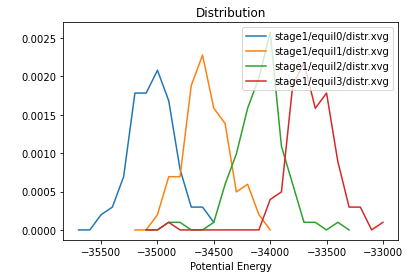

In [103]:
import glob
import numpy as np
import matplotlib.pyplot as plt
max_row= 23
all_files = glob.glob("" + "stage1/equil?/distr.xvg")
x , y = np.zeros((len(all_files),max_row)), np.zeros((len(all_files),max_row))
for file_num, file in enumerate(all_files):
    df = open(file)
    for col,line in enumerate(df):
        x_len = col
        cols = line.split()
        x[file_num,col]=float(cols[0])
        y[file_num,col]=float(cols[1])
    plt.plot(x[file_num,:x_len],y[file_num,:x_len], label= file)
plt.legend(loc="upper right")
plt.title("Distribution")    
plt.xlabel('Potential Energy')
plt.ylabel(' ')
plt.show()

In [15]:
less stage1/equil0/distr.xvg

To plot the distributions, we are going to use `Data->Transformation->Histograms` option. Select proper range and number of bins (around 20-25 should be good for our example). It is always a good idea to normilize histograms, although in our case they all have the same number of data points. Hide the energy progression graphs and autoscale the graphs, you should get a histogram like this one:
![Potential energy distribution histogramss of alanine tripeptide replicas.](figures/energies-hist-equil.png)

### Questions time

What do you like and what do you not like about these distributions? What would you improve in simulation setup and(or) analysis?

## Stage 2

### Preparing files

First, lets create folders and copy all files into them. We will need configuration (``.mdp``) file, state (``.cpt``) file, and initial configuration (``.gro``) file. The `sim.mdp` input file in each directory has a different temperature, and is set up to expect to continue the matching equilibration run (using ``sed``). Note that we are clearing the ``stage2`` folder.

In [ ]:
%%bash
rm -rf stage2
mkdir stage2
cd stage2
for i in {0..3}
do
    (mkdir sim$i; cp ../input/sim.mdp sim$i; cp ../stage1/equil$i/state.cpt sim$i; cp ../stage1/equil$i/confout.gro sim$i)
done

sed -i 's/XXXXXX/300/g' sim0/sim.mdp
sed -i 's/XXXXXX/310/g' sim1/sim.mdp
sed -i 's/XXXXXX/320/g' sim2/sim.mdp
sed -i 's/XXXXXX/330/g' sim3/sim.mdp

cd ..

To see the difference between equilibration and production files, run:

In [ ]:
!diff stage1/equil2/equil.mdp stage2/sim2/sim.mdp

Also, you can see that we are running a continuation, rather than generating new velocities that would only need equilibrating again! That the only differences between the simulation `.mdp` files are in the reference temperatures can be seen with commands like

In [ ]:
!diff stage2/sim[12]/sim.mdp

### Running a REMD simulation in GROMACS

Now let's use `gmx grompp` to prepare the input `.tpr` files, again using a `bash` loop to do the monkey work for us

In [ ]:
!(for directory in stage2/sim[0123]; do (cd $directory; gmx grompp -f sim.mdp -c confout.gro -p ../../prep/topol.top -t state.cpt); done)

This time we told `gmx grompp` to use the state from the equilibration `.cpt` file (option -t). Now it's time to run the REMD simulation using the MPI version of GROMACS.

In [ ]:
!mpirun -np 4 gmx_mpi mdrun -multidir stage2/sim[0123] -replex 100

This run will take a bit longer than the equilibration run, but is still only a "toy" run. We triggered the use of REMD with the `-replex` flag, which also specified that we will take 100 MD integration steps that should take place between exchange attempts. There's a bit of disagreement in the literature about how long that should be. Waiting around 1 ps seems wise in view of how long it takes to make an independent observation of the potential energy, so with a 2 fs time step in the `.mdp` file, around 500 steps between exchanges will be OK. Above, we did exchanges more often, just for the purposes of getting things to happen during the tutorial.

If you don't have good workstation, don't like the sound of spinning fans, or just tired of waiting, you can use the reference data. Uncommend and run the cell below.

In [ ]:
#!(rm -rf stage2; cp -r reference/stage2 .)

So, what happened? Let's look at one of the four `.log` files that were written. As example we look at the log file of simulation `sim1`.

In [ ]:
!cat stage2/sim1/md.log

and searching through it for the output peculiar to replica exchange. Fortunately, all of that is prefixed with the same string for replica exchange, so we can search for that with `Repl`.

You can see that `gmx_mpi mdrun` did some checking that you gave it a consistent set of input `.tpr` files. Further on you might see output like

    Replica exchange at step 100 time 0.20000
    Repl 0 <-> 1  dE_term =  3.595e+00 (kT)
    dpV =  4.901e-04  d =  3.596e+00
    Repl ex  0    1    2    3
    Repl pr   .03       .07

Here we see that at step 100 (which was the first attempt), the time was 0.2 ps. The potential energy of the state in ensemble 1 was about 3.60 kT higher than that of the state in ensemble 0, which meant that an exchange would only succeed about 3% of the time. Since this is the `md.log` file for simulation 1, we can't see the details for the exchange attempt between simulations 2 and 3, but if we open one of their `md.log` files, we would see those details.

Here we see the exchange attempt at step 11100 in my run. Note each run is a bit different (yours will be different from mine)

    Replica exchange at step 11100 time 22.20000
    Repl 0 <-> 1  dE_term = -6.689e-01 (kT)
    dpV =  3.677e-04  d = -6.685e-01
    Repl ex  0 x  1    2    3
    Repl pr   1.0       .02
    
At replica-exchange steps, GROMACS alternates between two disjoint sets of replica pairs, so that each replica attempts an exchange with both of its neighbours once every two attempts. This time, replica 1 had a potential energy that was lower than replica 0, so the exchange is certain to succeed. The same thing do not happen for replicas 2 and 3. Do read up on the [Metropolis criterion](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) if you need more information.

Down near the bottom of the `md.log` file you can see some summary statistics where the average exchange probabilities and number of exchange events are tabulated. In a real simulation, you might see that the distribution is not very uniform despite having run for several nanoseconds, and if so you might want to adjust your temperature scheme. Check out the literature for details.


### Question time

At the bottom of the `md.log` file you can see something like this:
```
Replica exchange statistics
Repl  1999 attempts, 1000 odd, 999 even
Repl  average probabilities:
Repl     0    1    2    3
Repl      .07  .07  .09
Repl  number of exchanges:
Repl     0    1    2    3
Repl       66   60   92
Repl  average number of exchanges:
Repl     0    1    2    3
Repl      .07  .06  .09
```
What does it tell you about the selected temperatures? Given, that the probabilities are less than empirical 20%, should the temperatures be closer to one another or further apart? Given the number of exchanges is different, which replicas should have closer temperatures and which should be adjusted to have the temperatures further apart?

### Note

The REMD statistics are accumulated only over each run, and are not stored in the `ener.edr` or `state.cpt` files, and can be lost if you use `md.log` file appending. So if you think you will want to post-process all your REMD statistics from a run in multiple stages, you will have to manage preserving all your `.log` files intact, e.g. by using `gmx_mpi mdrun -noappend` to avoid the default appending behaviour.

### Comparing potential energy distributions

First, let us check the potential energy distributions by repeating the steps we have done for the equilibration runs:

In [ ]:
!(for directory in stage2/sim[0123] ; do (cd $directory; gmx energy -f ener.edr -o ener.xvg -xvg none <<< $'Potential\n\n'); done)

In [ ]:
!xmgrace stage2/sim0/ener.xvg stage2/sim1/ener.xvg stage2/sim2/ener.xvg stage2/sim3/ener.xvg

As before, we are going to use `Data->Transformation->Histograms` option to plot histograms. You should get much better looking distributions.

### Question Time

The distributions look more simular to one another as compared to equilibration run. Which of the following did NOT contribute to that?

1. Better sampling.
2. Special conditions of the production run.
3. Tempering of the coordinates.
4. They start from structures, pre-equilibrated at a given temperature.


### De-multiplexing an REMD trajectory in GROMACS

There are two ways the programmer could implement REMD. At exchange attempts the replica simulations could exchange coordinates, or they could exchange temperatures. Other MD packages tend to exchange temperatures; GROMACS exchanges coordinates. This means that the trajectory written to a single file belongs to the ensemble described by the matching `.tpr` file. Often this is convenient, because you only want to look at the ensemble at your lowest temperature. Because of the exchanges, that trajectory will no longer be continuous - some totally different structure will appear every time an exchange happened. This will mean the time evolution of observables like RMS deviation over time from some other structure will show abrupt jumps.

There are some times you want a trajectory that has continuous coordinates, despite the "jumps" in ensemble space. This means chopping up each trajectory file into pieces and pasting them back together in the right order. The Perl script `demux.pl` installed with GROMACS will analyse a single REMD `.log` file and writes two special `.xvg` files that describe the transformation matrices for the trajectory time series from one form to the other, and back. `gmx_mpi trjcat -demux` can use these files to do the cut-and-paste on the trajectory files for you.

For convinience, there is a copy of a demux script that comes with this tutorial. Normally it can be found in the scripts folder of the GROMACS distribution.

This command will create a graph, showing how the replicas were exchanging over the course of the simulation:

In [ ]:
!(cd stage2/sim0; ../../../demux.pl md.log; xmgrace -block replica_index.xvg -bxy 1:2 -bxy 1:3 -bxy 1:4 -bxy 1:5)

### Sampling

To see if the sampling was appropriate, we are going to be checking backbone dihedrals of the central alanine of our tri-peptide. The ``gmx chi`` command will help us computing these dihedrals. Since we want to see how well, the landscape was explored, we have added ``-rama`` option to the command below. This will create Ramachandran plots for all amino-acids in the system.

In [ ]:
!(cd stage2/sim0; gmx chi -s topol.tpr -f traj_comp.xtc -rama; xmgrace ramaPhiPsiALA2.xvg)

Alanine tripeptide is not big enough to assume any stable conformation, hence it should visit all possible secondary structure regions of the plot. Allowed regions on the Ramachandran plot are: 
![Ramachandran plot.](figures/Ramachandran_plot_original_outlines.jpg)

### Question

In your simulations, do you see the system visiting

1. Only beta-sheet region
2. Only alpha-helical region
3. Both alpha and beta regions
4. Most or all allowed stated
5. I used the reference data

## Did we need REMD for a system that small?

Generally speaking, no. We could get good sampling in a very short time for a system that small. But to show that REMD helps, let us run a trajectory at 300K without any tempering. We will use the same configuration file that we used for the first replica in REMD run.

Create the folder and prepare the files:

In [ ]:
%%bash
rm -rf stage2-noremd
mkdir stage2-noremd
cd stage2-noremd

cp ../input/sim.mdp .
cp ../stage1/equil0/state.cpt .
cp ../stage1/equil0/confout.gro .

sed -i 's/XXXXXX/300/g' sim.mdp

cd ..

In [ ]:
!(cd stage2-noremd; gmx grompp -f sim.mdp -c confout.gro -p ../prep/topol.top -t state.cpt; gmx mdrun)

In [ ]:
#!(rm -rf stage2-noremd; cp -r reference/stage2-noremd .)

In [ ]:
!(cd stage2-noremd; gmx chi -s topol.tpr -f traj_comp.xtc -rama; xmgrace ramaPhiPsiALA2.xvg)

### Question

In your simulations, do you see the system visiting

1. Only beta-sheet region
2. Only alpha-helical region
3. Both alpha and beta regions
4. Most or all allowed stated
5. I used the reference data

### Question

What do you think would be a better temperature set for our system?

1. 300, 315, 330, 345K
2. 300, 308, 316, 332K
3. 300, 308, 318, 330K
4. Ours is better of all the above


## Conclusion

Here we've scratched the surface of the possibilities of replica-exchange. There are lots of fancy ways to change the physics of the replicas from which you don't want to sample, in order to enhance the sampling at the one you do want to sample, including actually changing the Hamiltonian!